In [15]:
# imports and laodings
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import statistics

# settings
central_gene = 'b1817'
basal_conditions = ['control__wt_glc__1', 'control__wt_glc__2'] #'crp__delar1ar2_glyc__2'

A_df = pd.read_csv('../data/precise_1.0/A.csv', index_col = 0)
iM_table = pd.read_csv('../data/precise_1.0/iM_table.csv', index_col = 0)
A_df = A_df.rename(index = {index : row['name'] for index, row in iM_table.iterrows()})

M_df = pd.read_csv('../data/precise_1.0/M.csv', index_col = 0)
M_df = M_df.rename(columns = {str(index) : row['name'] for index, row in iM_table.iterrows()})

log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)
A_df = A_df[log_tpm_df.columns]

# loading in
df_name = central_gene+'_zerodTrue_mRNA_ratios_and_MA_vals.csv'
ratios_df = pd.read_csv('../data/saved_mRNA_ratios_MA_vals/'+df_name, index_col = 0)
f_name = central_gene+'_zerodTrue_cAct_cInh_vals.csv'
cActInh_df = pd.read_csv('../data/save_for_GAMs/'+f_name, index_col = 0)

# defining constants
#RNAP = 1*10**(-8)
RNAP = 1*10**(-7)
kEscape = 1
TF = 0
#u = 1/3600
#kDeg = 0.00231049
#promoterConc = 1*10**(-9)
#promoterConcVal = 10**(-9)
#cell_volume = 10**(-15) # in liters

# getting grid values
pickle_in = open('../data/pickle_dicts/center_cond_to_gene_to_grid_values.pkl', 'rb')
center_cond_to_gene_to_grid_values = pickle.load(pickle_in)
pickle_in.close()
grid_vals = center_cond_to_gene_to_grid_values[basal_conditions[0]]['b1101']
grid_use = -3
KdRNAP = 10**(grid_vals[grid_use][0])
kEscape = 10**(grid_vals[grid_use][1])
KeqOpening = 10**(grid_vals[grid_use][2])
KdRNAPCrp = 2.5118864315095796e-07*1.4

print(KdRNAP)
#print(kEscape)
print(KeqOpening)

if True:
    def mRNA_to_cActivator(mRNA, RNAP = RNAP, KdRNAP = KdRNAP, KdRNAPCrp = KdRNAPCrp, KeqOpening = KeqOpening): # this appears to be properly working!
        cActivator = (KdRNAPCrp*(KdRNAP + RNAP + KeqOpening*RNAP)*(-1 + \
                mRNA))/(KdRNAP*(KdRNAP + RNAP + KeqOpening*RNAP - \
                KdRNAPCrp*mRNA - RNAP*mRNA - KeqOpening*RNAP*mRNA))

        return(cActivator)

    def mRNA_to_cInhibitor(mRNA, RNAP = RNAP, KdRNAP = KdRNAP, KeqOpening = KeqOpening): # I think the mathematica code might have an error, I'm sticking with this
        cInhibitor = -(((KdRNAP + RNAP + KeqOpening*RNAP)*(-1 + mRNA))/(KdRNAP*mRNA))

        return(cInhibitor)


    def cActivator_cInhibitor_to_mRNA(cActivator, cInhibitor, RNAP = RNAP, KdRNAP = KdRNAP, KdRNAPCrp = KdRNAPCrp, KeqOpening = KeqOpening):
        mRNA = ((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
                KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
                cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
                KeqOpening)*RNAP)

        return(mRNA)

    def log_tpm_to_mRNA_conc(val):
        mRNA = (2**val)*(10**-6)*1800/cell_volume/(6.022*(10**23))
        return(mRNA)

1e-05
0.4524289955987184


# optimize KdRNAPCrp

In [16]:
ratios_df

,MA_activator,MA_inhibitor,actual_mRNA_ratio
control__wt_glc__1,0.025470,0.028431,0.954296
control__wt_glc__2,-0.025470,-0.028431,1.047893
fur__wt_dpd__1,-1.279881,-0.472513,0.247064
fur__wt_dpd__2,-1.483073,-0.540305,0.230053
fur__wt_fe__1,0.058052,-0.054727,0.774145
...,...,...,...
efeU__menFentCubiC_ale36__2,-0.257701,-0.128666,0.617425
efeU__menFentCubiC_ale37__1,-0.237224,-0.057749,0.533889
efeU__menFentCubiC_ale37__2,-0.215005,-0.091809,0.532469
efeU__menFentCubiC_ale38__1,0.060063,-0.312698,0.639904


1e-05


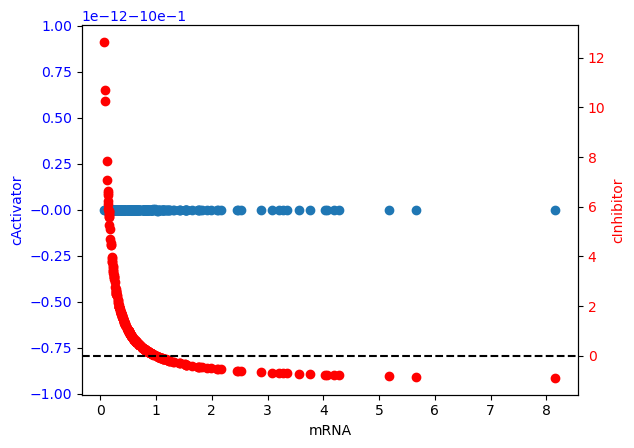

6.309573444801933e-06


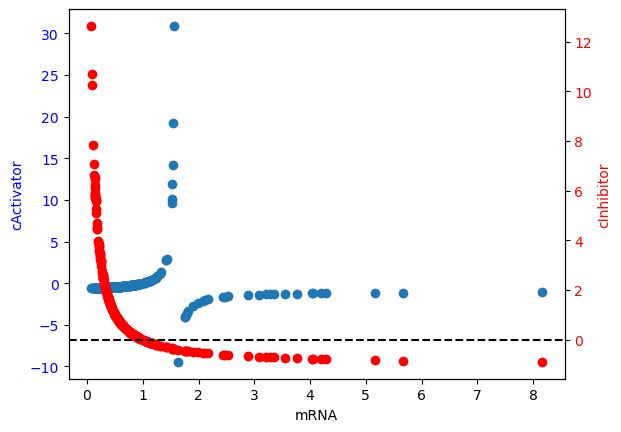

3.9810717055349725e-06


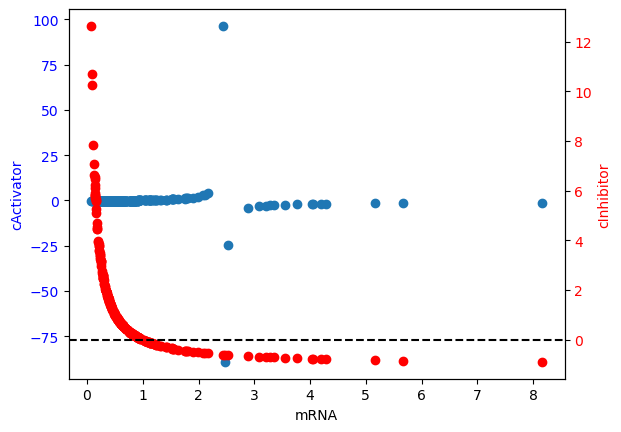

2.51188643150958e-06


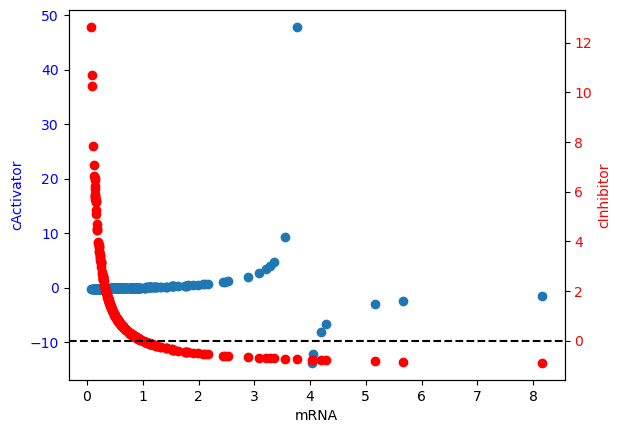

1.5848931924611137e-06


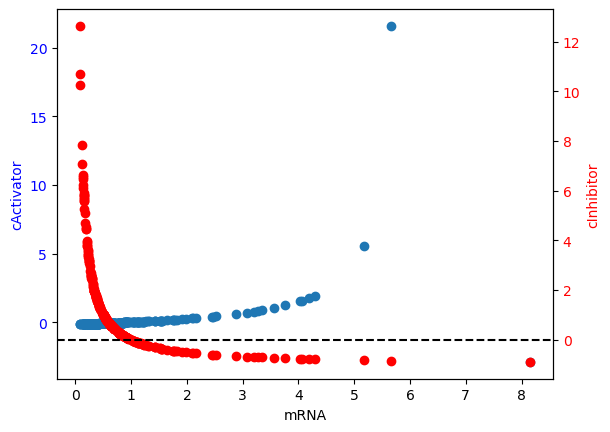

1.0000000000000002e-06


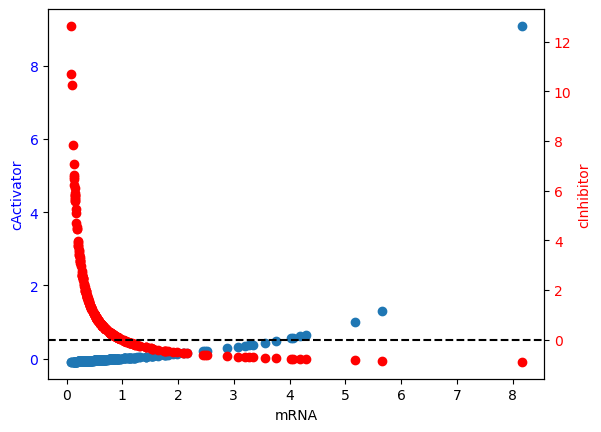

6.309573444801934e-07


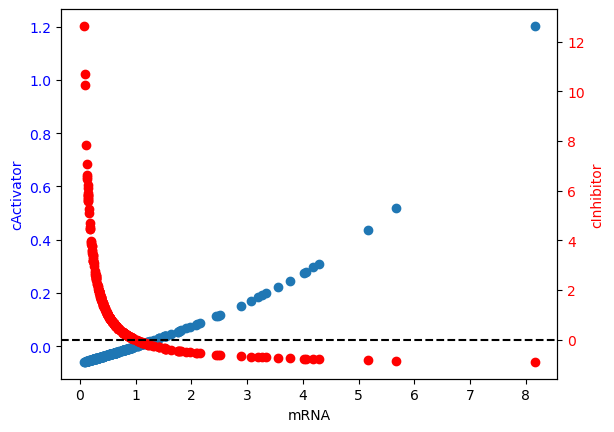

3.981071705534974e-07


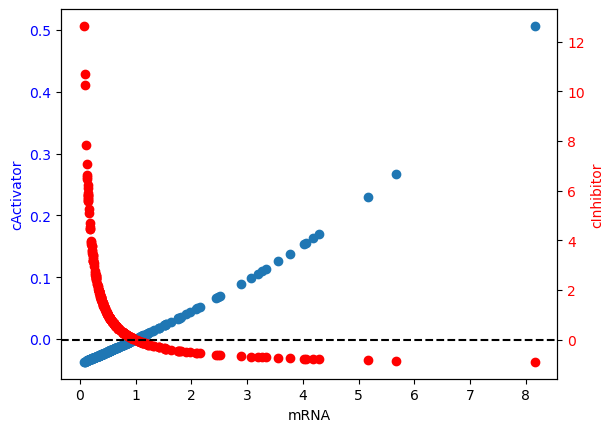

2.5118864315095796e-07


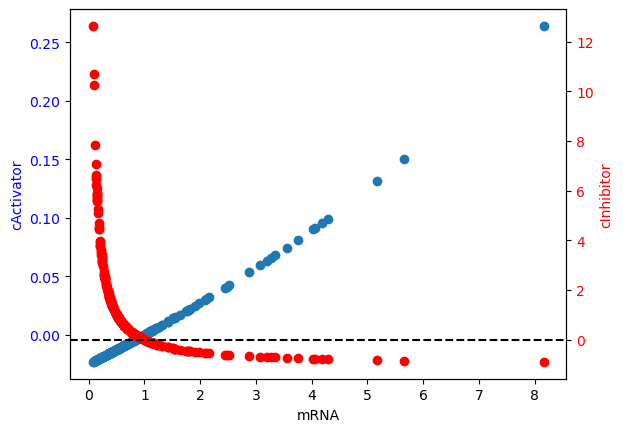

1.5848931924611136e-07


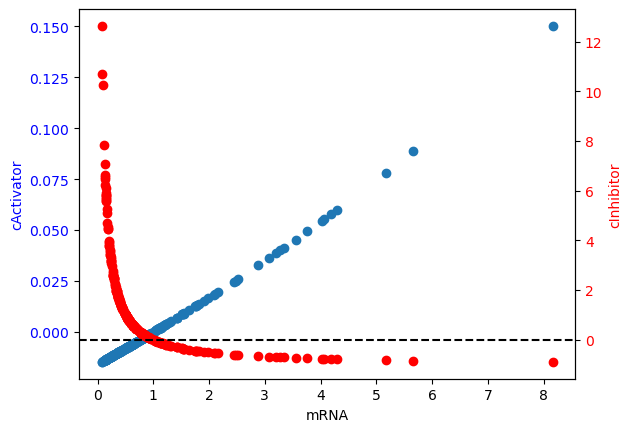

1.0000000000000001e-07


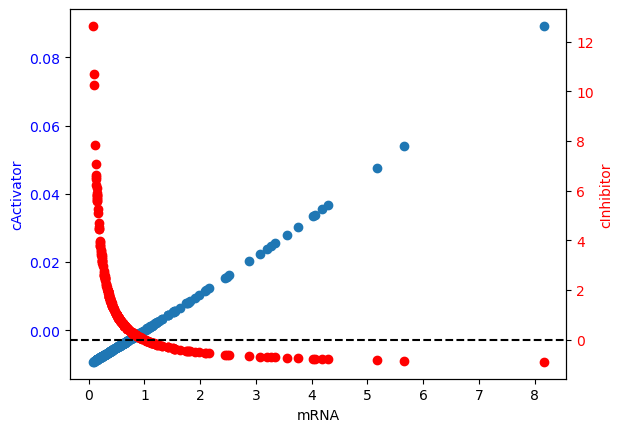

6.309573444801931e-08


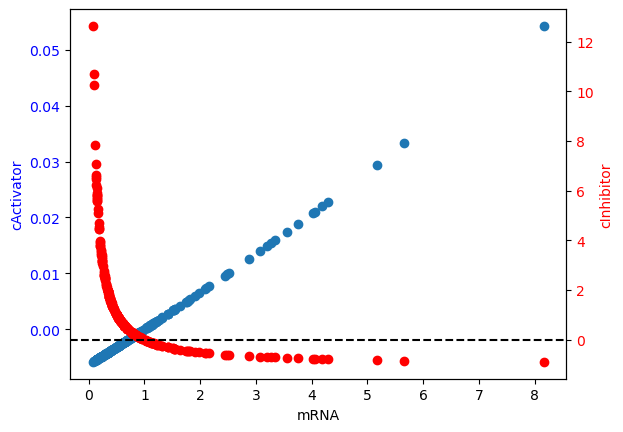

3.9810717055349736e-08


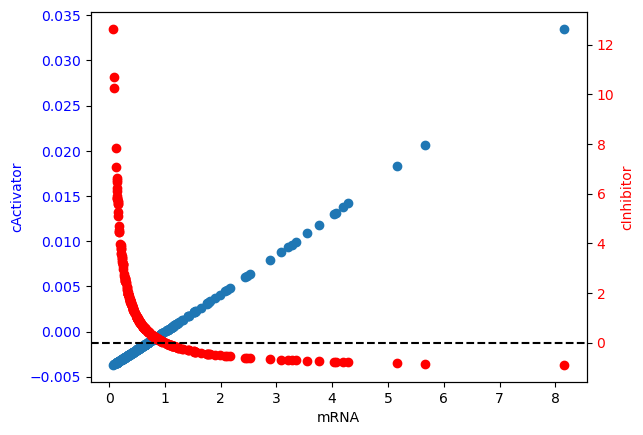

2.5118864315095798e-08


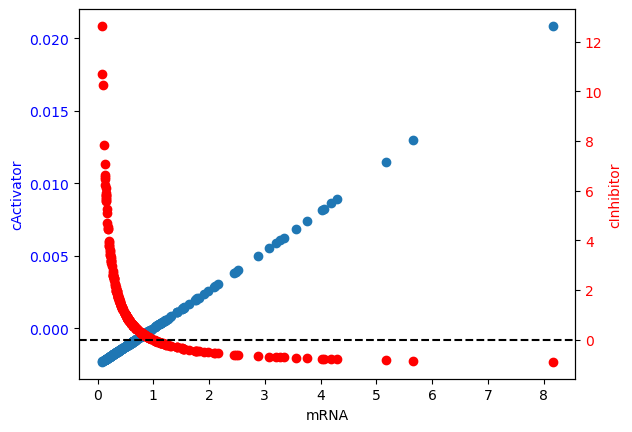

1.5848931924611143e-08


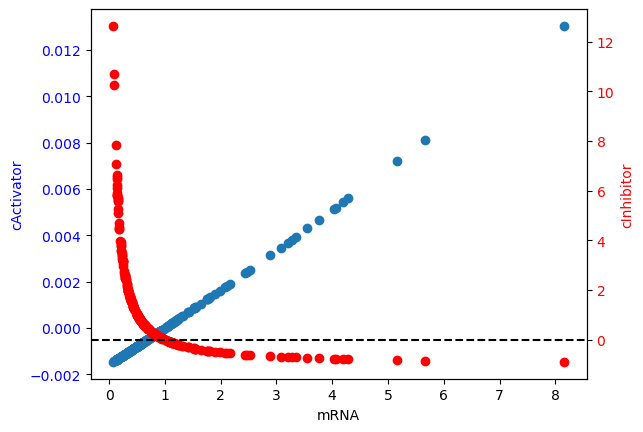

1e-08


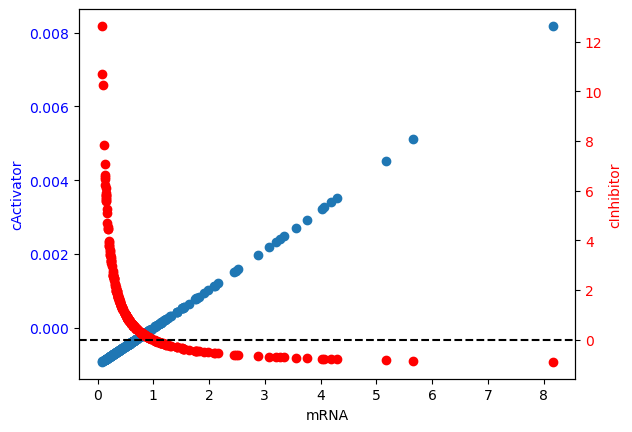

6.3095734448019305e-09


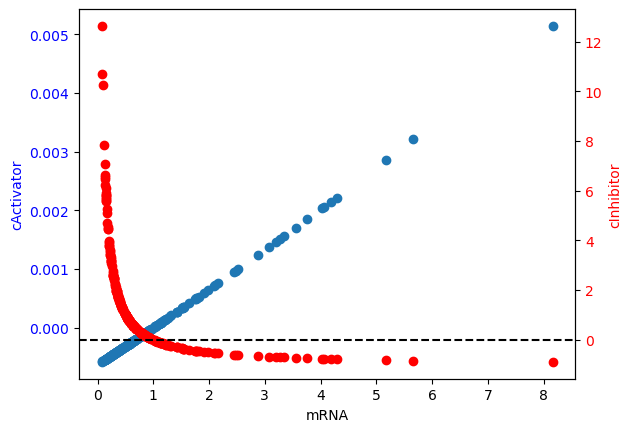

3.981071705534974e-09


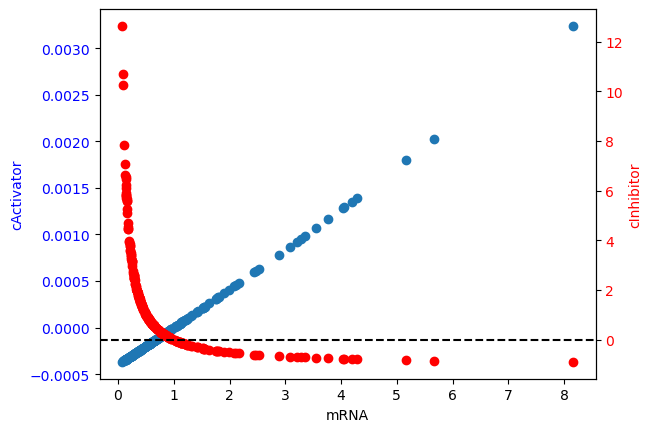

2.51188643150958e-09


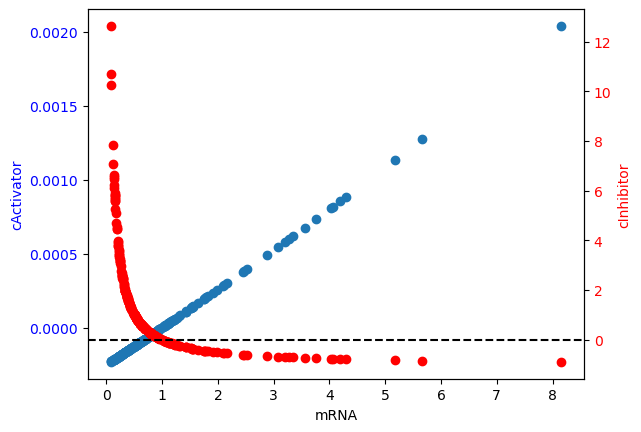

1.5848931924611142e-09


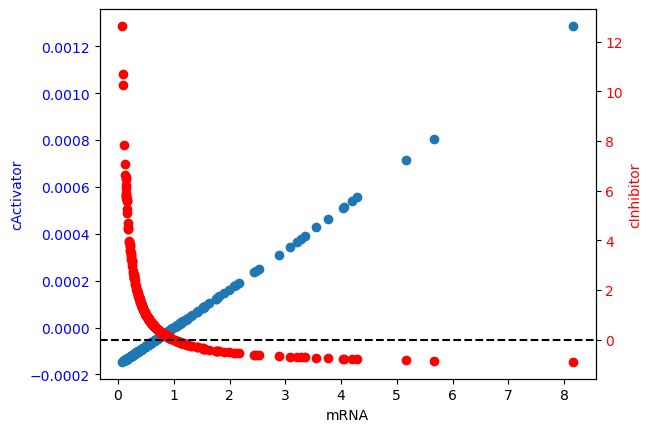

In [17]:
# Dan's suggestion - set cInhibitor to 0 to study cActivator and sweep values of KdRNAPCrp
# cInhibitor is not dependent on KdRNAPCrp so this doesn't really matter to it


# plot
for val in range(20):
    KdRNAPCrp_temp = KdRNAP*10**(-val/5)
    print(KdRNAPCrp_temp)
    fig, ax = plt.subplots()
    vals = mRNA_to_cActivator(ratios_df['actual_mRNA_ratio'], KdRNAPCrp = KdRNAPCrp_temp)
    ax.scatter(ratios_df['actual_mRNA_ratio'], vals)
    plt.xlabel('mRNA')
    ax.set_ylabel('cActivator', color = 'blue')
    ax.tick_params(axis = 'y', labelcolor = 'blue')
    #ax.set_ylim(-max(abs(vals)), max(abs(vals)))
    ax2 = ax.twinx()
    vals = mRNA_to_cInhibitor(ratios_df['actual_mRNA_ratio'])
    ax2.scatter(ratios_df['actual_mRNA_ratio'], vals, color = 'red')
    ax2.set_ylabel('cInhibitor', color = 'red')
    ax2.tick_params(axis = 'y', labelcolor = 'red')
    #ax2.set_ylim(-max(abs(vals)), max(abs(vals)))
    #plt.axvline(x = log_tpm_to_mRNA_conc(log_tpm_df[controls].loc['b1101'].mean()), linestyle = '--', color = 'k')
    #plt.axvline(x = act_values_df.loc[controls]['mRNA'].mean(), linestyle = 'dotted', color = 'k')
    ax2.axhline(y = 0, linestyle = '--', color = 'k')
    plt.show()